<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Inference" data-toc-modified-id="Inference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Inference</a></span></li></ul></div>

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from pmdarima.model_selection import SlidingWindowForecastCV

plt.style.use("dark_background")

In [2]:
data = pd.read_csv("./Datasets/Ethereum/ETH_USD.csv", skiprows=1, parse_dates=["Date"], index_col="Date")

data = data.drop(["Symbol","Unix Timestamp"] , axis=1)
data = data.sort_index()

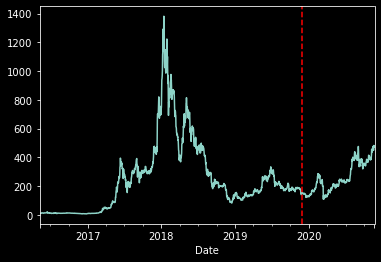

In [310]:
test_size = 360
cutoff = data.index.max() - timedelta(days=test_size)
data_tr, data_te = train_test_split(data["Close"], test_size=test_size, shuffle=False)

data["Close"].plot.line();
plt.axvline(x=cutoff, c="red", ls="--");

In [311]:
def blocked_cv(data, window_size, h):
    X = list()
    y = list()
    for i in range(len(data) - window_size - h + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + h])
    return np.array(X), np.array(y)

window_size = 60
h = 12
tr_X, tr_y = blocked_cv(data_tr, window_size, h)
tr_X = tr_X[:, :, None]

# window_size = 60
# h = 7
# cv = SlidingWindowForecastCV(h=h, step=1, window_size=60)
# cv_gen = cv.split(data_tr)

# tr_X = list()
# tr_y = list()
# for i in cv_gen:
#     tr_X.append(data_tr[i[0]])
#     tr_y.append(data_tr[i[1]])
# tr_X = np.array(tr_X)[:, :, None]
# tr_y = np.array(tr_y)

# Modeling

In [312]:
inputs = Input(shape=(window_size, 1))

z = Conv1D(filters=64, kernel_size=2, activation="relu", input_shape=(window_size, 1))(inputs)
z = MaxPool1D(pool_size=2)(z)
z = Flatten()(z)
z = Dense(units=50, activation="relu")(z)
outputs = Dense(units=h, activation="relu")(z)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="mae", metrics=["mae"])
model.summary()

es = EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=4)
hist = model.fit(x=tr_X, y=tr_y, validation_split=0.2, shuffle=True, epochs=32, batch_size=64, callbacks=[es])

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 60, 1)]           0         
                                                                 
 conv1d_23 (Conv1D)          (None, 59, 64)            192       
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 29, 64)           0         
 g1D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 1856)              0         
                                                                 
 dense_26 (Dense)            (None, 50)                92850     
                                                                 
 dense_27 (Dense)            (None, 12)                612       
                                                          

In [313]:
# inputs = Input(shape=(window_size, 1))

# z = Conv1D(filters=64, kernel_size=2, activation="relu", input_shape=(window_size, 1))(inputs)
# z = MaxPool1D(pool_size=2)(z)
# z = Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(window_size, 1))(z)
# z = MaxPool1D(pool_size=2)(z)
# z = Conv1D(filters=256, kernel_size=2, activation="relu", input_shape=(window_size, 1))(z)
# z = MaxPool1D(pool_size=2)(z)
# z = Flatten()(z)
# z = Dense(units=50, activation="relu")(z)
# outputs = Dense(units=1, activation="relu")(z)

# model = Model(inputs=inputs, outputs=outputs)

# model.compile(optimizer="adam", loss="mae", metrics=["mae"])
# model.summary()

# es = EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=4)
# model_path = "eth_cnn.h5"
# hist = model.fit(x=tr_X, y=tr_y, validation_split=0.2, shuffle=True, epochs=32, batch_size=64, callbacks=[es])

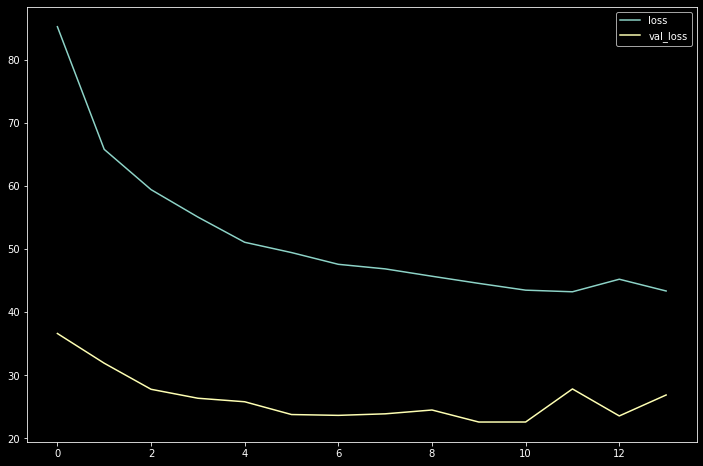

In [314]:
fig, axes = plt.subplots(figsize=(12, 8))
axes.plot(hist.history["loss"][1:], label="loss");
axes.plot(hist.history["val_loss"][1:], label="val_loss");
axes.legend();

# Inference

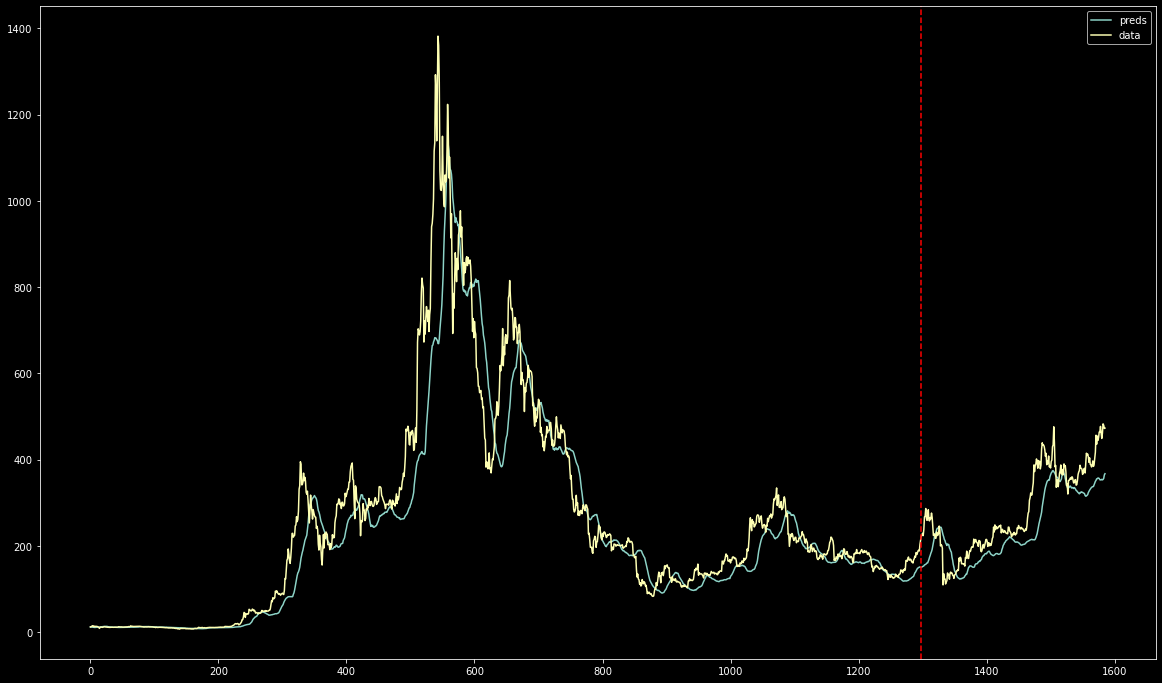

In [315]:
X, y = blocked_cv(data["Close"], window_size, h)
X = X[:, :, None]

preds = model.predict(X)

plt.subplots(figsize=(20, 12))
plt.plot(preds[:, -1], label="preds");
plt.plot(np.array(data["Close"].iloc[window_size + h - 1:]), label="data");
plt.legend();
plt.axvline(x=len(data) - test_size, c="red", ls="--");